<center><h1>  1. zadaća </h1></center>
<center><h1>Algoritmi za određivanje konveksne ljuske skupa točaka </h1></center>

<i><center>Podatci nad kojima su se vršila testiranja i primjene iskonstruirani su u sklopu ove zadaće.
    U narednim blokovima odrađeni su svi uvozi modula i paketa potrebnih i korištenih u radu. </center></i>

In [1]:
%%javascript
//onemogućavanje scrollbara u output blokovima, omogućeno koristeći JavaScript kod 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
# Moduli i paketi

import numpy as np
import pandas as pd
import random as rand
import functools as func
import time
import matplotlib.animation
import matplotlib.pyplot as plt
import pylab as pylab
from IPython.display import display, Image
import matplotlib.image as mpimg

<h2> Uvod </h2>

Konveksna ljuska nekog skupa $S$ je najmanji konveksni skup $D$ koji sadrži dani skup. Određivanje takvog skupa i algoritmi koji se pritom koriste imaju raznoliku primjenu o kojoj će biti riječi nešto kasnije. Za početak ćemo matematički definirati osnovne pojmove vezane uz temu ovoga rada. 

$ \textbf{Definicija 1.} $
 Kažemo da je skup $ D \subseteq \mathbb{R}^{n} $ konveksan ako za bilo koje dvije točke $ x_{1}, x_{2} \in \mathbb{R}^{n} $ sadrži i segment određen tim točkama.

$$ x_{1}, x_{2} \in D \Rightarrow \lambda x_{1} + ( 1 - \lambda ) x_{2}  \in D , \:\: \forall \lambda \in [ 0, 1 ]$$

U nastavku slijedi primjer konveksnog i nekonveksnog peterokuta.

<h6> Primjer 1. </h6>
Konveksni i nekonveksni peterokut

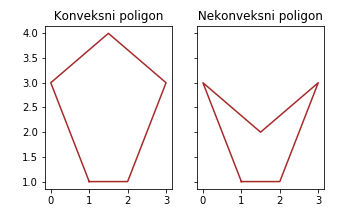

In [11]:
# Primjer 1.
display( Image( filename='test_data/primjer1.png' ) )

$ \textbf{Definicija 2.} $ Neka je skup $ S  \subseteq \mathbb{R}^{n}$. Konveksna ljuska skupa $ S $ je skup svih konveksnih kombinacija točaka iz $ S $. 
$$ conv(S) = \{ \lambda_{1}x_{1} + \lambda_{2}x_{2} + ... + \lambda_{m}x_{m} : x_{1}, x_{2}, ... , x_{m} \in S, \: \lambda_{1}, \lambda_{2}, ... , \lambda_{m} \in [0, 1],  \sum\limits_{1}^{m} \lambda_{i} = 1 \} $$
Drugim riječima, konveksna ljuska je najmanji konveksni skup koji sadrži skup S.

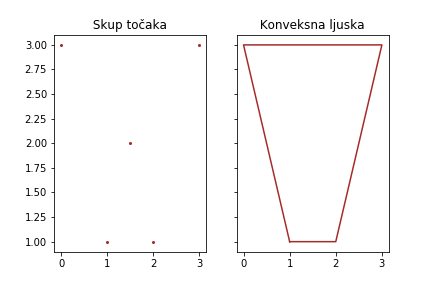

In [12]:
# Primjer 2.
display( Image( filename='test_data/primjer2.png' ) )

<h3> O algoritmima </h3> 
- o algoritmima 
- navedeni najpopularniji algoritmi 
- opis pomoćnih funkcija 
- implementacija pomoćnih funkcja $\checkmark$

U ovom radu baviti ćemo se određivanjem konveksne ljuske nekog skupa točaka iz ravnine.

In [8]:
# funkcija lijeva_baza provjerava u kojem smjeru se tocka C nastavlja na segment AB
# vraca pozitivan rezultat ukoliko se C nalazi lijevo gledajuci od A prema B pa k C
# vraca negativan rezultat ukoliko se C nalazi desno gledajuci od A prema B pa k C
# te vraca nulu ukoliko su te tri tocke kolinearne

def Mleft_turn( point_A, point_B, point_C):
    return (( point_A[0] * (point_B[1] - point_C[1])) 
            + point_B[0] * (point_C[1] - point_A[1]) 
            + point_C[0] * (point_A[1] - point_B[1]));



In [9]:
Q_ = [2, 0] 
W_ = [0, 2]
X_ = [1, 1]
Y_ = [1, 2]
Z_ = [1, 3]

print( Mleft_turn(X_,Y_,Z_) )
print( Mleft_turn(X_,Y_,W_) )
print( Mleft_turn(X_,Y_,Q_) )

# nacrtati ?

0
1
-1


In [10]:
# kako nam trebaju samo omjeri udaljenosti, a ne same vrijednosti udaljenosti možemo računati kvadrat,
# te izostaviti računanje korijena

def Mdistance( point_A, point_B):
    return (  ( point_A[0] - point_B[0])**2 
            + ( point_A[1] - point_B[1])**2);

In [11]:
print( Mdistance(X_,Y_) > Mdistance(Y_,Z_))
print( Mdistance(X_,Y_) >= Mdistance(Y_,X_))

False
True


In [12]:
# kao početnu točku tražim najnižu točku ili onu najlijeviju, dakle onu s najmanjom y vrijednosti
# ukoliko dvije točke imaju jednaku najmanju y vrijednost, tražimo onu "lijeviju", dakle s manjom x vrijednosti

def Mlowest_point( array_points ):
    minY = array_points[0]
    for point in array_points:
        if (   ( point[1] < minY[1] ) 
            or ( point[1] == minY[1] and point[0] < minY[0] ) ):
            minY = point
    return minY

def Mleftmost_point( array_points ):
    minX = array_points[0]
    for point in array_points:
        if (   ( point[0] < minX[0] ) 
            or ( point[0] == minX[0] and point[1] < minX[1] ) ):
            minX = point
    return minX

In [13]:
def function_for_sort( x, y ):  
    global P_0
    coef = Mleft_turn(P_0, x, y)
    if coef > 0 :
        return -1
    elif coef == 0:
        if Mdistance(P_0, x) < Mdistance(P_0, y):
            return -1
    return 1

<h2> Graham algoritam </h2>

- opcenito o algoritmu
- pseudokod  $\checkmark$
- implementacija ( dio po dio )$\checkmark$
- graf $\checkmark$
- animacija?

<center><h4> Određivanje konveksne ljuske za skup S koji se sastoji od  n točaka </h4></center> 

1. Odrediti početnu točku, $P_{0}$
2. Sortirati sve ostale točke po polarnom kutu s ozirom na točku $P_{0}$
3. Na stog staviti zadnju pa prvu točku sortirane liste
4. Ponavljati n-2 puta : 
Za sljedeću točku u sortiranoj listi provjeriti čine li    dvije vršne točke sa stoga s njom lijevi okret
<br> Da : stavljamo i novu točku na stog
<br> Ne : izbacujemo točku s vrha stoga


In [14]:
def Graham( array_of_points ):
    new_array = list(array_of_points)
    global P_0 
    P_0 = Mleftmost_point( new_array )
    new_array.remove( P_0 )
    new_array = sorted( new_array, key=func.cmp_to_key(function_for_sort))
    Convex_hull = []
    Convex_hull.append(new_array[-1])
    Convex_hull.append( P_0 )
    index = 0
    size = len(new_array)
    while( index != size ):
        examination_point = new_array[index]
        if ( Mleft_turn( Convex_hull[-2], Convex_hull[-1], examination_point ) > 0 ):
            Convex_hull.append( examination_point )
            index += 1
        else:
            Convex_hull.pop()
    return Convex_hull


In [15]:
Example_set = [[1,1], [0,1], [3,3], [1.5,2], [0, 3],[1,2]]
Convex = Graham( Example_set )
print("Konveksna ljuska:")

for x in Convex:
    print("(",x[0],",",x[1],"), ");

Konveksna ljuska:
( 0 , 3 ), 
( 0 , 1 ), 
( 1 , 1 ), 
( 3 , 3 ), 
( 0 , 3 ), 


In [16]:
# generiranje skupa od 200 random točaka
array_ = []
for x in range(200):
    point = [ rand.randint(1,100), rand.randint(1,100) ]
    array_.append(point)

ConvexHull_array = Graham( array_ )
P_0 = Mleftmost_point( array_ )

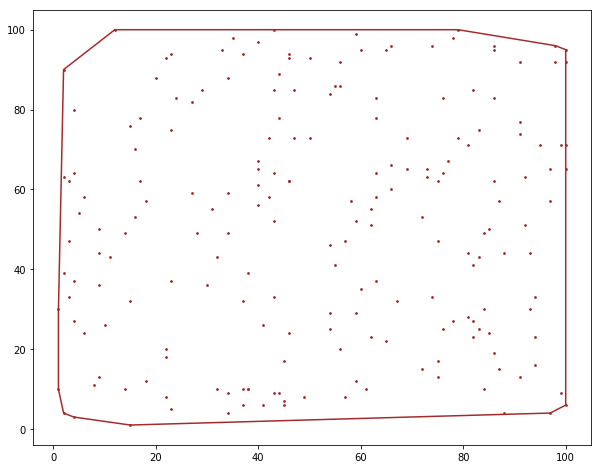

In [17]:
%matplotlib inline

# grafički prikaz točaka i pripadne konveksne ljuske
ConvexHull_array.append(ConvexHull_array[0])
x1, y1 = zip(*array_)
x2, y2 = zip(*ConvexHull_array) 
 


Hull = plt.figure(figsize=(10,8))
ax1 = Hull.add_subplot(111)
ax1.scatter( x1, y1, color='brown', s=3)
ax1.plot( x2, y2, color='brown')

plt.show()

In [18]:
def Graham_construct_animation( array_of_points ):
    animate_Convex_hull =[]
    new_array = list(array_of_points)
    global P_0 
    P_0 = Mleftmost_point( new_array )
    new_array.remove( P_0 )
    new_array = sorted( new_array, key=func.cmp_to_key(function_for_sort))
    Convex_hull = []
    Convex_hull.append(new_array[-1])
    Convex_hull.append( P_0 )
    index = 0
    temp = 0
    size = len(new_array)
    while( index != size ):
        temp = temp + 1
        examination_point = new_array[index]
        Convex_hull.append( examination_point)
        animate_Convex_hull.append(Convex_hull[1:-1])
        Convex_hull.remove( examination_point)
        if ( Mleft_turn( Convex_hull[-2], Convex_hull[-1], examination_point ) > 0 ):
            Convex_hull.append( examination_point )
            index += 1
        else:
            Convex_hull.pop()
            
    Convex_hull.append(Convex_hull[0])
    animate_Convex_hull.append(Convex_hull)
    return animate_Convex_hull


In [20]:

Example_array = []
for x in range(50):
    point = [ rand.randint(1,100), rand.randint(1,100) ]
    Example_array.append(point)

Scatter_pointsX, Scatter_pointsY =  zip(*Example_array)
ConvexHull_animation =  Graham_construct_animation( Example_array ) 

fig, ax = plt.subplots()
ax.axis([0,100, 0, 100])
ax.scatter(Scatter_pointsX, Scatter_pointsY, s = 2, color = 'black' )
l, = ax.plot([],[])

def animate(i, Convex_data, ax):
    top = len(Convex_data)
    if i >= 1 and  i<= top:
        processing_data = Convex_data[i] 
        x_axes, y_axes = zip(*processing_data)
        l.set_data(x_axes[:i], y_axes[:i])
    
%matplotlib inline

ani = matplotlib.animation.FuncAnimation(fig, animate, len(ConvexHull_animation),fargs=( ConvexHull_animation, ax))

from IPython.display import HTML
HTML(ani.to_jshtml())

TODO :   Obradti specijalni slučaj : točke unutar kruga 

<h2> Jarvis march </h2>

- opcenito o algoritmu
- pseudokod
- implementacija ( dio po dio )
- graf
- animacija?

<h2> Primjena </h2>

- nabrojati primjere
- implementacija ( dio po dio )

<h2> 3D konveksne ljuske ( konveksna zatvorenja ) </h2>
- nagovještaj 